In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("MI_DB.csv", index_col=0)
# Replace to NaN and convert to float
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric)

### Filter out columns with too much NA values

In [7]:
record_count = df.count().to_numpy()
indexes_high_na = np.where( record_count < 1700/2)[0]

name_dropped = df.columns[indexes_high_na].to_numpy() #Keep track of the names of the columns we drop
df = df.drop(df.columns[indexes_high_na], axis = 1)



In [8]:
treshold_na = int(0.3*119) # if more that 50% of missing values, get rid of the row (59)
print("Treshold:",treshold_na)

def calculate_NA(row):
    return row.isna().sum().sum()

df["n_NA"] = df.apply(calculate_NA, axis=1)

np.max(df["n_NA"])

df = df.drop(df[df["n_NA"] > treshold_na].index)
df = df.drop(["n_NA"], axis=1)

df["DEAD"] = df["LET_IS"].apply(lambda x: 1 if x > 0 else 0)

Treshold: 35


### Separate features by type (ordinal/binary/numeric)

In [9]:
numeric_attributes = ["AGE","S_AD_KBRIG","D_AD_KBRIG","S_AD_ORIT","D_AD_ORIT","K_BLOOD","NA_BLOOD",
                      "ALT_BLOOD","AST_BLOOD","KFK_BLOOD","L_BLOOD","ROE"]

numeric_attributes = [x for x in numeric_attributes if x not in name_dropped]

ord_attributes = ["INF_ANAM","STENOK_AN","FK_STENOK","IBS_POST","GB","DLIT_AG","ZSN_A",
                  "ant_im","lat_im","inf_im","post_im","R_AB_1_n","NA_R_1_n","NOT_NA_1_n",
                 "R_AB_2_n","NA_R_2_n","NOT_NA_2_n","R_AB_3_n","NA_R_3_n","NOT_NA_3_n","TIME_B_S"]


ord_attributes = [x for x in ord_attributes if x not in name_dropped]

Y_labels = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS","DEAD"]

att_names = list(df.columns)

bin_attributes = [x for x in att_names if x not in numeric_attributes+ord_attributes+Y_labels]
bin_attributes = [x for x in bin_attributes if x not in name_dropped]

colums_id_Y = [df.columns.get_loc(c) for c in Y_labels if c in df]

#### Note: the data set is quite imbalanced, but there is no missing values in the outcome features

## Impute the missing values with KNN-impute

In [10]:
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

scaler = preprocessing.StandardScaler()

pipe = make_pipeline(scaler, KNNImputer(n_neighbors=10))

imputer = KNNImputer(n_neighbors=3)
df_i = pipe.fit_transform(df)
df_i = scaler.inverse_transform(df_i)

sf_df = pd.DataFrame(df_i, index=df.index, columns=df.columns)

# Round the ordinal values to int

In [11]:
sf_df[ord_attributes]= sf_df[ord_attributes].apply(round,axis=1)

sf_df[bin_attributes]= sf_df[bin_attributes].apply(round,axis=1)

sf_df_dum = pd.get_dummies(sf_df, columns=ord_attributes)

### Correlation matrix

## Separate X and Y

In [18]:
x_cols = bin_attributes+ord_attributes+numeric_attributes
y_cols = Y_labels

x_cols = [x for x in sf_df_dum.columns if x not in Y_labels]

X = sf_df_dum[x_cols]
Y = sf_df_dum[y_cols]

scaler.fit(X)
X_sc = scaler.transform(X)
Y_dead = Y["DEAD"].to_numpy()
Y_dead = Y_dead.round().astype(int)

In [19]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
ros = RandomOverSampler(random_state=0)
smo = SMOTE()

In [20]:
Y_dead

array([0, 0, 0, ..., 1, 1, 1])

# Train a model

Fitting 15 folds for each of 75 candidates, totalling 1125 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 448 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best estimator: Pipeline(memory=None,
         steps=[('sgd',
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.0,
                               learning_rate='optimal', loss='log',
                               max_iter=10000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
Fitting 15 folds for each of 75 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best estimator: Pipeline(memory=None,
         steps=[('sgd',
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.0,
                               learning_rate='optimal', loss='log',
                               max_iter=10000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
Fitting 15 folds for each of 75 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.5min finished


best estimator: Pipeline(memory=None,
         steps=[('sgd',
                 SGDClassifier(alpha=0.021544346900318822, average=False,
                               class_weight=None, early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.0, learning_rate='optimal',
                               loss='log', max_iter=10000, n_iter_no_change=5,
                               n_jobs=None, penalty='elasticnet', power_t=0.5,
                               random_state=None, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)
Fitting 15 folds for each of 75 candidates, totalling 1125 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best estimator: Pipeline(memory=None,
         steps=[('sgd',
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.0,
                               learning_rate='optimal', loss='log',
                               max_iter=10000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
Fitting 15 folds for each of 75 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.6min finished


best estimator: Pipeline(memory=None,
         steps=[('sgd',
                 SGDClassifier(alpha=0.021544346900318822, average=False,
                               class_weight=None, early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.0, learning_rate='optimal',
                               loss='log', max_iter=10000, n_iter_no_change=5,
                               n_jobs=None, penalty='l2', power_t=0.5,
                               random_state=None, shuffle=True, tol=0.001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False))],
         verbose=False)
0.6873723446131615


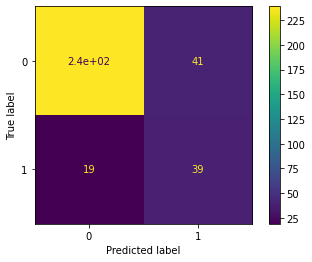

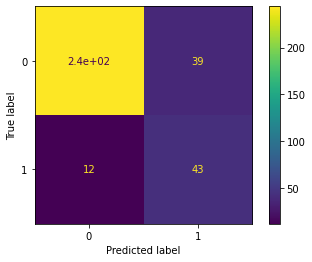

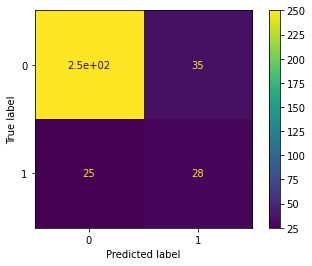

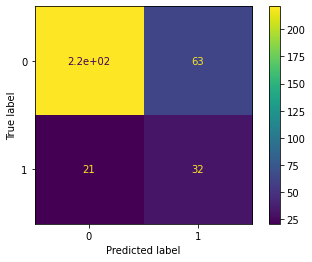

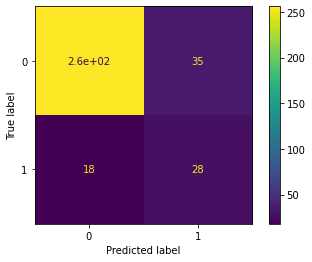

In [27]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score,plot_confusion_matrix
from sklearn.pipeline import Pipeline

inner_cv = KFold(n_splits=5, shuffle=True)
scores = []
models = []

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train, x_test = X_sc[train_ids],X_sc[test_ids]
    y_train, y_test = Y_dead[train_ids],Y_dead[test_ids]
    
    x_train, y_train =  ros.fit_resample(x_train, y_train)
    
    param_grid = {
        'sgd__alpha': np.logspace(-4,4,25),
        "sgd__penalty": ["l1","l2","elasticnet"],
        "sgd__l1_ratio": np.linspace(0,0.1,1),
        "sgd__loss" : ['log']
    }

    model = Pipeline([
                          ("sgd",SGDClassifier(max_iter=10000))])
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    cv_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, verbose=2, n_jobs=-1,scoring="roc_auc")

    cv_grid.fit(x_train, y_train)
    print(f'best estimator: {cv_grid.best_estimator_}')
    models.append(cv_grid.best_estimator_)

    y_pred = cv_grid.predict(x_test)
    plot_confusion_matrix(cv_grid, x_test, y_test)  
    scores.append(balanced_accuracy_score(y_pred,y_test))

print(np.mean(scores))

In [43]:
name, model = models[0].steps[0]
model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.0,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 10000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [52]:
# Better evaluate the models



score_matrix = []

for a in range(30):
  inner_cv = KFold(n_splits=3, shuffle=True)
  for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
      x_train, x_test = X_sc[train_ids],X_sc[test_ids]
      y_train, y_test = Y_dead[train_ids],Y_dead[test_ids]
      
      x_train, y_train =  ros.fit_resample(x_train, y_train)
      scores = []
      for model_pip in models:
        name, model = model_pip.steps[0]
        para = model.get_params()
        model = SGDClassifier(**para)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        scores.append(balanced_accuracy_score(y_pred,y_test))

      score_matrix.append(scores)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

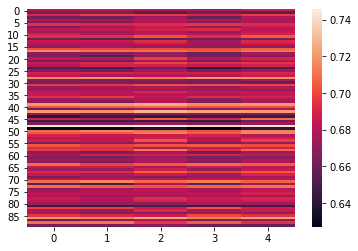

In [53]:
sns.heatmap(score_matrix)

In [54]:
np.mean(score_matrix)

0.6825682709270263